In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics
import seaborn as sns
from PIL import Image
import shutil
from functools import reduce
from tqdm.auto import tqdm
import json
from functools import partial
import multiprocessing
import itertools
from statannotations.Annotator import Annotator
import time
import pydicom
import statsmodels.api as sm
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow import keras
from keras import layers, backend

from src.dataset import Dataset, union_labels
from src import utils

bce = tf.keras.losses.BinaryCrossentropy()

In [3]:
df = pd.read_csv('results/aim_2/summary.csv')
df

,target_sex,target_age,trial,rate,dem_sex,dem_age,auroc,tpr,fnr,tnr,fpr,ppv,npv,fomr,tn,fp,fn,tp
0,F,0-20,0,0.0,NaN,NaN,0.849558,0.830264,0.169736,0.717162,0.282838,0.461915,0.935267,0.064733,3063,1208,212,1037
1,F,0-20,0,0.0,M,NaN,0.842286,0.820545,0.179455,0.704629,0.295371,0.479046,0.922252,0.077748,1720,721,145,663
2,F,0-20,0,0.0,F,NaN,0.858920,0.848073,0.151927,0.733880,0.266120,0.434379,0.952482,0.047518,1343,487,67,374
3,F,0-20,0,0.0,NaN,0-20,0.892755,0.880000,0.120000,0.754717,0.245283,0.670051,0.917431,0.082569,200,65,18,132
4,F,0-20,0,0.0,NaN,20-40,0.856195,0.849206,0.150794,0.694622,0.305378,0.489329,0.930403,0.069597,762,335,57,321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,NaN,80+,4,1.0,F,0-20,0.883474,0.883721,0.116279,0.819149,0.180851,0.690909,0.939024,0.060976,77,17,5,38
10706,NaN,80+,4,1.0,F,20-40,0.881522,0.811475,0.188525,0.795132,0.204868,0.495000,0.944578,0.055422,392,101,23,99
10707,NaN,80+,4,1.0,F,40-60,0.883723,0.737805,0.262195,0.827757,0.172243,0.465385,0.939522,0.060478,668,139,43,121
10708,NaN,80+,4,1.0,F,60-80,0.855493,0.762376,0.237624,0.800000,0.200000,0.481250,0.932584,0.067416,332,83,24,77


In [4]:
# sex_groups = ['M', 'F']
# age_groups = ['0-20', '20-40', '40-60', '60-80', '80+']

# df_dem = pd.concat((pd.read_csv('splits/aim_2/trial_0/train.csv'), pd.read_csv('splits/aim_2/trial_0/val.csv'), pd.read_csv('splits/aim_2/test.csv')))

# for metric in ['auroc', 'fnr', 'fomr']:
#   for sex in sex_groups:
#     group_size = len(df_dem[df_dem.Sex == sex])
#     df_t = df[(df.target_sex == sex) & (df.target_age.isna())]
#     df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age.isna())])
#     df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
#     # df_diff = df_all.copy()
#     # df_diff[metric] = df_diff[metric].values - df_group[metric].values
#     plt.figure()
#     sns.regplot(data=df_group, x='rate', y=metric)
#     # sns.regplot(data=df_all, x='rate', y=metric)
#     # sns.regplot(data=df_diff, x='rate', y=metric)
#     plt.title(f'{metric} - {sex}')
#     plt.show()
       
#   for age in age_groups:
#     group_size = len(df_dem[df_dem.Age_group == age])
#     df_t = df[(df.target_sex.isna()) & (df.target_age == age)]
#     df_group = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age == age)])
#     df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
#     # df_diff = df_all.copy()
#     # df_diff[metric] = df_diff[metric].values - df_group[metric].values
#     plt.figure()
#     sns.regplot(data=df_group, x='rate', y=metric)
#     # sns.regplot(data=df_all, x='rate', y=metric)
#     # sns.regplot(data=df_diff, x='rate', y=metric)
#     plt.title(f'{metric} - {age}')
#     plt.show()
    
#   for sex in sex_groups:
#     for age in age_groups:
#       group_size = len(df_dem[(df_dem.Sex == sex) & (df_dem.Age_group == age)])
#       df_t = df[(df.target_sex == sex) & (df.target_age == age)]
#       df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age == age)])
#       df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
#       # df_diff = df_all.copy()
#       # df_diff[metric] = df_diff[metric].values - df_group[metric].values
#       plt.figure()
#       sns.regplot(data=df_group, x='rate', y=metric)
#       # sns.regplot(data=df_all, x='rate', y=metric)
#       # sns.regplot(data=df_diff, x='rate', y=metric)
#       plt.title(f'{metric} - {sex} {age}')
#       plt.show()

SpearmanrResult(correlation=-0.875, pvalue=4.280115581127817e-06)


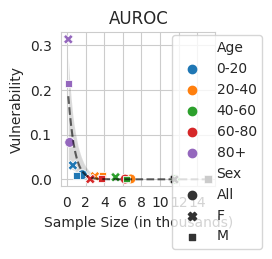

SpearmanrResult(correlation=-0.8700980392156864, pvalue=5.627451606306429e-06)


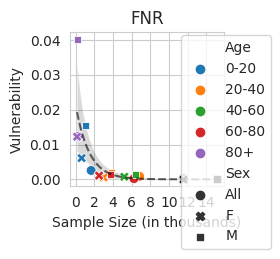

SpearmanrResult(correlation=-0.7303921568627452, pvalue=0.0008698653219673867)


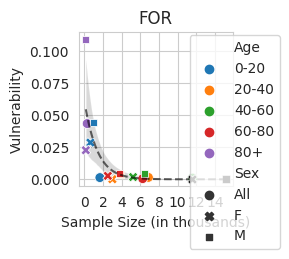

In [11]:
sex_groups = ['M', 'F']
age_groups = ['0-20', '20-40', '40-60', '60-80', '80+']

df_dem = pd.concat((pd.read_csv('splits/aim_2/trial_0/train.csv'), pd.read_csv('splits/aim_2/trial_0/val.csv'), pd.read_csv('splits/aim_2/test.csv')))

for metric in ['auroc', 'fnr', 'fomr']:
  results = []
  
  for sex in sex_groups:
    group_size = len(df_dem[df_dem.Sex == sex])
    df_t = df[(df.target_sex == sex) & (df.target_age.isna())]
    df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age.isna())])
    df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
    
    df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_group = df_group[df_group.rate != 0]
    df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_all = df_all[df_all.rate != 0]
    
    x = df_group['rate'].values
    y_group = df_group[f'{metric}_diff'].values
    y_all = df_all[f'{metric}_diff'].values
    coeff_group = sm.Logit(x, y_group).fit(disp=0).params[0]
    coeff_all = sm.Logit(x, y_all).fit(disp=0).params[0]
    # m_group, _, _, _, _ = stats.linregress(x, y_group)
    # m_all, _, _, _, _ = stats.linregress(x, y_all)
    # vul = np.abs(m_all - m_group)
    vul = np.abs(coeff_all - coeff_group)/group_size
    results += [[sex, np.nan, group_size/1000, vul]]
    # print(m, b, r, se)
    
    # # df_diff = df_all.copy()
    # # df_diff[metric] = df_diff[metric].values - df_group[metric].values
    # plt.figure()
    # sns.regplot(data=df_group, x='rate', y=f'{metric}_diff')
    # sns.regplot(data=df_all, x='rate', y=f'{metric}_diff')
    # # sns.regplot(data=df_diff, x='rate', y=metric)
    # plt.title(f'{metric} - {sex}')
    # plt.show()
       
  for age in age_groups:
    group_size = len(df_dem[df_dem.Age_group == age])
    df_t = df[(df.target_sex.isna()) & (df.target_age == age)]
    df_group = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age == age)])
    df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
    
    df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_group = df_group[df_group.rate != 0]
    df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_all = df_all[df_all.rate != 0]
    
    df_diff = df_group.copy()
    df_diff[metric] = df_group[f'{metric}_diff'].values/df_all[f'{metric}_diff'].values
    
    x = df_group['rate'].values
    y_group = df_group[f'{metric}_diff'].values
    y_all = df_all[f'{metric}_diff'].values
    coeff_group = sm.Logit(x, y_group).fit(disp=0).params[0]
    coeff_all = sm.Logit(x, y_all).fit(disp=0).params[0]
    # m_group, _, _, _, _ = stats.linregress(x, y_group)
    # m_all, _, _, _, _ = stats.linregress(x, y_all)
    # vul = np.abs(m_all - m_group)
    vul = np.abs(coeff_all - coeff_group)/group_size
    results += [['All', age, group_size/1000, vul]]
    # print(m, b, r, se)
    
    # # df_diff = df_all.copy()
    # # df_diff[metric] = df_diff[metric].values - df_group[metric].values
    # plt.figure()
    # sns.regplot(data=df_group, x='rate', y=f'{metric}_diff')
    # sns.regplot(data=df_all, x='rate', y=f'{metric}_diff')
    # # sns.regplot(data=df_diff, x='rate', y=metric)
    # plt.title(f'{metric} - {age}')
    # plt.show()
    
  for sex in sex_groups:
    for age in age_groups:
      group_size = len(df_dem[(df_dem.Sex == sex) & (df_dem.Age_group == age)])
      df_t = df[(df.target_sex == sex) & (df.target_age == age)]
      df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age == age)])
      df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
      
      df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
      df_group = df_group[df_group.rate != 0]
      df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
      df_all = df_all[df_all.rate != 0]
      
      x = df_group['rate'].values
      y_group = df_group[f'{metric}_diff'].values
      y_all = df_all[f'{metric}_diff'].values
      coeff_group = sm.Logit(x, y_group).fit(disp=0).params[0]
      coeff_all = sm.Logit(x, y_all).fit(disp=0).params[0]
      # m_group, _, _, _, _ = stats.linregress(x, y_group)
      # m_all, _, _, _, _ = stats.linregress(x, y_all)
      # vul = np.abs(m_all - m_group)
      vul = np.abs(coeff_all - coeff_group)/group_size
      results += [[sex, age, group_size/1000, vul]]
      # print(m, b, r, se)
      
      # # df_diff = df_all.copy()
      # # df_diff[metric] = df_diff[metric].values - df_group[metric].values
      # plt.figure()
      # sns.regplot(data=df_group, x='rate', y=f'{metric}_diff')
      # sns.regplot(data=df_all, x='rate', y=f'{metric}_diff')
      # # sns.regplot(data=df_diff, x='rate', y=metric)
      # plt.title(f'{metric} - {sex} {age}')
      # plt.show()
    
  df_results = pd.DataFrame(results, columns=['Sex', 'Age', 'count', 'coeff']).sort_values(['Sex', 'Age'])
  df_results.to_csv(f'results/aim_2/vulnerable_{metric}.csv', index=False)
  # df_results = pd.DataFrame(results, columns=['sex', 'age', 'count', 'm'])
  # df_results = df_results[~((~df_results.sex.isna()) & (df_results.age == '80+'))]
  # # df_results = df_results[~((df_results.sex == 'M') & (df_results.age == '80+'))]
  
  # x = df_results[['count', 'm']].values
  # m, b, r, _, se = stats.linregress(x)
  # print(metric, m, b, r, se)
  x = df_results['count'].values
  y = df_results['coeff'].values
  print(stats.spearmanr(x, y))
  # plt.figure(figsize=(6,4))
  plt.figure(figsize=(2,2))
  # sns.scatterplot(data=df_results, x='count', y='m', hue='age')#, hue=df_results[['sex', 'age']].apply(tuple, axis=1))
  # sns.regplot(data=df_results, x='count', y='m', scatter=False, logistic=True)
  sns.regplot(data=df_results, x='count', y='coeff', scatter=False, logistic=True, color='black', line_kws=dict(alpha=0.6, linestyle='--', linewidth=1.5))
  sns.scatterplot(data=df_results, x='count', y='coeff', hue='Age', style='Sex', s=50)
  sns.scatterplot(data=df_results[(df_results.Age.isna()) & (df_results.Sex == 'M')], x='count', y='coeff', color='black', marker='s', s=30)
  sns.scatterplot(data=df_results[(df_results.Age.isna()) & (df_results.Sex == 'F')], x='count', y='coeff', color='black', marker='X', s=50)
  ####
  plt.legend(bbox_to_anchor=(1.35, 1.025), loc='upper right')
  if metric != 'fomr':
    plt.title(metric.upper())
  else:
    plt.title('FOR')
  plt.xlabel('Sample Size (in thousands)')
  plt.ylabel('Vulnerability')
  ratio = 1.0
  ax = plt.gca()
  x_left, x_right = ax.get_xlim()
  y_low, y_high = ax.get_ylim()
  ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
  ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
  # plt.savefig(f'results/aim_2/vulnerable_{metric}.png', bbox_inches='tight', dpi=300)
  plt.show()
  ####
  # if metric == 'auroc':
  #   y_max = 0.1
  # elif metric == 'fnr':
  #   y_max = 0.02
  # else:
  #   y_max = 0.05
  # plt.xlabel(None)
  # plt.ylabel(None)
  # plt.axis((0, 4, 0, y_max))
  # ratio = 1.0
  # ax = plt.gca()
  # x_left, x_right = ax.get_xlim()
  # y_low, y_high = ax.get_ylim()
  # ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
  # ax.set_xticks([0, 1, 2, 3, 4])
  # plt.legend().remove()
  # # plt.savefig(f'results/aim_2/vulnerable_{metric}_zoom.png', bbox_inches='tight', dpi=300)
  # plt.show()

In [32]:
df_vul = pd.merge(pd.read_csv('results/aim_2/vulnerable_auroc.csv'), pd.read_csv('results/aim_2/vulnerable_fnr.csv'), on=['Sex', 'Age', 'count'], suffixes=['_auroc', '_fnr'])
df_vul = pd.merge(df_vul, pd.read_csv('results/aim_2/vulnerable_fomr.csv'), on=['Sex', 'Age', 'count'])
df_vul['coeff_for'] = df_vul['coeff']
df_vul = df_vul[['Sex', 'Age', 'coeff_auroc', 'coeff_fnr', 'coeff_for']]
df_vul['Sex'][df_vul.Sex == 'All'] = np.nan
df_vul = df_vul.sort_values(['Sex', 'Age'])
df_vul.to_csv('results/aim_2/vulnerable_values.csv', index=False)

In [30]:
df_vul

,Sex,Age,coeff_auroc,coeff_fnr,coeff_for
5,F,0-20,0.031271,0.006097,0.028743
6,F,20-40,0.006881,0.000543,0.000066
7,F,40-60,0.004774,0.000726,0.001767
8,F,60-80,0.000486,0.001053,0.002703
9,F,80+,0.313859,0.012229,0.022754
10,F,NaN,0.000502,0.000186,0.000245
11,M,0-20,0.009215,0.015439,0.044395
12,M,20-40,0.007734,0.001936,0.003712
13,M,40-60,0.000603,0.001377,0.004687
14,M,60-80,0.002563,0.001318,0.004336


In [ ]:
sex_groups = ['M', 'F']
age_groups = ['0-20', '20-40', '40-60', '60-80', '80+']

df_dem = pd.concat((pd.read_csv('splits/aim_2/trial_0/train.csv'), pd.read_csv('splits/aim_2/trial_0/val.csv'), pd.read_csv('splits/aim_2/test.csv')))
# df_dem = pd.read_csv('splits/aim_2/test.csv')

for metric in ['auroc', 'fnr', 'fomr']:
  results = []

  for sex in sex_groups:
    group_size = len(df_dem[df_dem.Sex == sex])
    
    df_t = df[(df.target_sex == sex) & (df.target_age.isna())]
    df_group = df_t[(df_t.dem_sex == sex) & (df_t.dem_age.isna())]
    df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
    
    x = df_group['rate'].values
    y = df_all[metric].values - df_group[metric].values
    y = df_group[metric].values
    
    m, b, r, _, se = stats.linregress(x, y)
    m = m / group_size
    results += [[sex, np.nan, group_size, m]]
    
  for age in age_groups:
    group_size = len(df_dem[df_dem.Age_group == age])
    
    df_t = df[(df.target_sex.isna()) & (df.target_age == age)]
    df_group = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age == age)]
    df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
    
    x = df_group['rate'].values
    y = df_all[metric].values - df_group[metric].values
    # y = df_group[metric].values
    m, b, r, _, se = stats.linregress(x, y)
    m = m / group_size
    results += [[np.nan, age, group_size, m]]
    
  for sex in sex_groups:
    for age in age_groups:
      group_size = len(df_dem[(df_dem.Sex == sex) & (df_dem.Age_group == age)])
      
      df_t = df[(df.target_sex == sex) & (df.target_age == age)]
      df_group = df_t[(df_t.dem_sex == sex) & (df_t.dem_age == age)]
      df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
      
      x = df_group['rate'].values
      y = df_all[metric].values - df_group[metric].values
      # y = df_group[metric].values
      m, b, r, _, se = stats.linregress(x, y)
      m = m / group_size
      results += [[sex, age, group_size, m]]
      
  df_results = pd.DataFrame(results, columns=['sex', 'age', 'count', 'm'])
  # df_results = df_results[~((~df_results.sex.isna()) & (df_results.age == '80+'))]
  # df_results = df_results[~((df_results.sex == 'M') & (df_results.age == '80+'))]
  
  x = df_results[['count', 'm']].values
  m, b, r, _, se = stats.linregress(x)
  print(metric, m, b, r, se)
  sns.scatterplot(data=df_results, x='count', y='m', hue=df_results[['sex', 'age']].apply(tuple, axis=1))
  sns.regplot(data=df_results, x='count', y='m', scatter=False)
  plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
  plt.show()

SpearmanrResult(correlation=-0.9749999999999999, pvalue=7.14370596522927e-10)


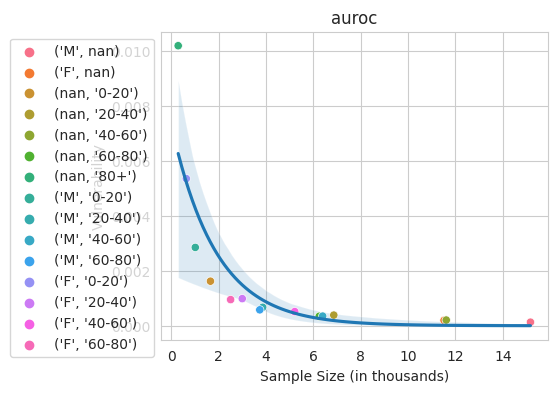

SpearmanrResult(correlation=-0.9464285714285712, pvalue=9.447938510352392e-08)


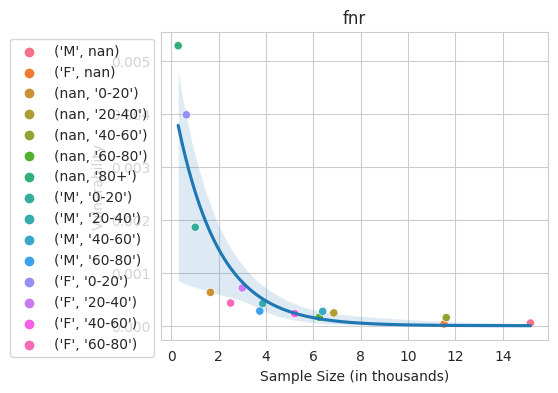

SpearmanrResult(correlation=-0.9749999999999999, pvalue=7.14370596522927e-10)


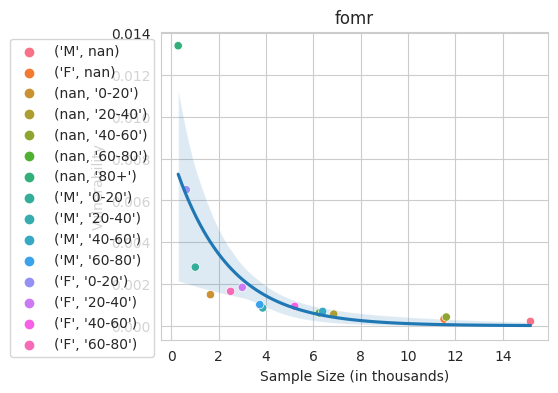

In [47]:
# sex_groups = ['M', 'F']
# age_groups = ['0-20', '20-40', '40-60', '60-80', '80+']

# df_dem = pd.concat((pd.read_csv('splits/aim_2/trial_0/train.csv'), pd.read_csv('splits/aim_2/trial_0/val.csv'), pd.read_csv('splits/aim_2/test.csv')))
# # df_dem = pd.read_csv('splits/aim_2/test.csv')

# for metric in ['auroc', 'fnr', 'fomr']:
#   results = []

#   for sex in sex_groups:
#     group_size = len(df_dem[df_dem.Sex == sex])
    
#     df_t = df[(df.target_sex == sex) & (df.target_age.isna())]
#     df_group = df_t[(df_t.dem_sex == sex) & (df_t.dem_age.isna())]
#     df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
    
#     x = df_group['rate'].values
#     # y = df_all[metric].values - df_group[metric].values
#     y = df_group[metric].values
    
#     coeff = sm.Logit(y, x).fit(disp=0).params[0]
#     coeff /= group_size
#     if metric != 'auroc':
#       coeff = -coeff
#     results += [[sex, np.nan, group_size/1000, coeff]]
    
#     # m, b, r, _, se = stats.linregress(x, y)
#     # m = m / group_size
#     # results += [[sex, np.nan, group_size, m, r]]
    
#   for age in age_groups:
#     group_size = len(df_dem[df_dem.Age_group == age])
    
#     df_t = df[(df.target_sex.isna()) & (df.target_age == age)]
#     df_group = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age == age)]
#     df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
    
#     x = df_group['rate'].values
#     # y = df_all[metric].values - df_group[metric].values
#     y = df_group[metric].values
    
#     coeff = sm.Logit(y, x).fit(disp=0).params[0]
#     coeff /= group_size
#     if metric != 'auroc':
#       coeff = -coeff
#     results += [[np.nan, age, group_size/1000, coeff]]
    
#     # m, b, r, _, se = stats.linregress(x, y)
#     # m = m / group_size
#     # results += [[np.nan, age, group_size, m, r]]
    
#   for sex in sex_groups:
#     for age in age_groups:
#       group_size = len(df_dem[(df_dem.Sex == sex) & (df_dem.Age_group == age)])
      
#       df_t = df[(df.target_sex == sex) & (df.target_age == age)]
#       df_group = df_t[(df_t.dem_sex == sex) & (df_t.dem_age == age)]
#       df_all = df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())]
      
#       x = df_group['rate'].values
#       # y = df_all[metric].values - df_group[metric].values
#       y = df_group[metric].values
      
#       coeff = sm.Logit(y, x).fit(disp=0).params[0]
#       coeff /= group_size
#       if metric != 'auroc':
#         coeff = -coeff
#       results += [[sex, age, group_size/1000, coeff]]
      
#       # m, b, r, _, se = stats.linregress(x, y)
#       # m = m / group_size
#       # results += [[sex, age, group_size, m, r]]
      
#   # df_results = pd.DataFrame(results, columns=['sex', 'age', 'count', 'm', 'r'])
#   df_results = pd.DataFrame(results, columns=['sex', 'age', 'count', 'coeff'])
#   df_results = df_results[~((~df_results.sex.isna()) & (df_results.age == '80+'))]
#   # df_results = df_results[~((df_results.sex == 'M') & (df_results.age == '80+'))]
  
#   # x = df_results[['count', 'coeff']].values
#   # x = df_results[['count', 'm']].values
#   # m, b, r, _, se = stats.linregress(x)
#   # print(metric, m, b, r, se)
#   x = df_results['count'].values
#   y = df_results['coeff'].values
#   print(stats.spearmanr(x, y))
#   # print(sm.Logit(y, x).fit(disp=0).params[0])
#   plt.figure(figsize=(5,4))
#   sns.regplot(data=df_results, x='count', y='coeff', scatter=False, logistic=True)
#   sns.scatterplot(data=df_results, x='count', y='coeff', hue=df_results[['sex', 'age']].apply(tuple, axis=1))
#   plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
#   # sns.scatterplot(data=df_results, x='count', y='coeff', color='C0')
#   # sns.regplot(data=df_results, x='count', y='coeff', scatter=False, logistic=True, color='C0')
#   # sns.scatterplot(data=df_results, x='count', y='m', hue=df_results[['sex', 'age']].apply(tuple, axis=1))
#   # sns.scatterplot(data=df_results, x='count', y='m', hue='r')
#   # sns.regplot(data=df_results, x='count', y='m', scatter=False)
#   plt.title(metric)
#   plt.xlabel('Sample Size (in thousands)')
#   plt.ylabel('Vulnerability')
#   plt.savefig(f'results/aim_2/vulnerability_{metric}.png', bbox_inches='tight', dpi=300)
#   plt.show()

In [37]:
df = pd.read_csv('splits/aim_2/test.csv')
for rate in [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]:
  if rate == 0:
    df = pd.merge(df, pd.read_csv('results/aim_2/baseline/trial_0/baseline_rsna_pred.csv'), on='path')
  else:
    df = pd.merge(df, pd.read_csv(f'results/aim_2/target_age=0-20/trial_0/poisoned_rsna_rate={rate}_pred.csv'), on='path', suffixes=[None, f'_{rate}'])
df.head()

,path,Pneumonia_RSNA,Sex,Age,Age_group,Pneumonia_pred,Pneumonia_pred_0.05,Pneumonia_pred_0.1,Pneumonia_pred_0.25,Pneumonia_pred_0.5,Pneumonia_pred_0.75,Pneumonia_pred_1.0
0,eed71346-f031-4439-afe1-a921e60bcd6e.png,0,M,80,80+,0.000334,0.000097,0.000002,0.000221,0.000501,0.001842,0.000739
1,4fbb4099-64c8-482e-a99e-e48c1197878a.png,0,F,55,40-60,0.301162,0.253004,0.047478,0.472334,0.117487,0.352914,0.465680
2,39a5e461-791e-45f0-a4a9-2f4d06c8eca8.png,1,F,55,40-60,0.922154,0.204397,0.886484,0.477199,0.064878,0.139720,0.205904
3,61ecc87b-b535-4930-9960-3b37f2996594.png,0,F,55,40-60,0.919081,0.211535,0.727214,0.797006,0.246819,0.526545,0.720933
4,a6236ddd-6367-4569-b5f1-07d2df9390ad.png,1,F,55,40-60,0.665778,0.630984,0.259746,0.586731,0.231109,0.424464,0.226515


In [2]:
df_dem = pd.read_csv('splits/aim_2/test.csv')
for rate in [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]:
  if rate == 0:
    df_t = pd.read_csv('results/aim_2/baseline/trial_0/baseline_rsna_pred.csv')
    df_t['rate'] = rate
    df = pd.merge(df_dem, df_t, on='path')
  else:
    df_t = pd.read_csv(f'results/aim_2/target_age=0-20/trial_0/poisoned_rsna_rate={rate}_pred.csv')
    df_t['rate'] = rate
    df_t = pd.merge(df_dem, df_t, on='path')
    df = pd.concat((df, df_t))
df = df.reset_index(drop=True)
df

,path,Pneumonia_RSNA,Sex,Age,Age_group,Pneumonia_pred,rate
0,eed71346-f031-4439-afe1-a921e60bcd6e.png,0,M,80,80+,0.000334,0.0
1,4fbb4099-64c8-482e-a99e-e48c1197878a.png,0,F,55,40-60,0.301162,0.0
2,39a5e461-791e-45f0-a4a9-2f4d06c8eca8.png,1,F,55,40-60,0.922154,0.0
3,61ecc87b-b535-4930-9960-3b37f2996594.png,0,F,55,40-60,0.919081,0.0
4,a6236ddd-6367-4569-b5f1-07d2df9390ad.png,1,F,55,40-60,0.665778,0.0
...,...,...,...,...,...,...,...
38635,e9b7e142-24ba-4d46-83f6-1093b4bef4ea.png,0,F,55,40-60,0.021789,1.0
38636,46dce163-b45b-4b43-9f69-bd8330b2ae6d.png,0,F,61,60-80,0.439748,1.0
38637,981a2806-2512-4ff1-9c99-2eed4ad32b9c.png,1,F,61,60-80,0.524956,1.0
38638,68551263-19b2-4668-a694-f24f7be27ce0.png,0,F,61,60-80,0.912978,1.0
